Obiettivo del task:
Sul dataset creato, calcolare il clustering basato sulle distanze Euclidea/Manhattan e il DTW
e confrontare i risultati.

Per eseguire il clustering è possibile scegliere diversi metodi di similarity (ad esempio):
- shape based

- feature-based

- approximation-based

- compression-based

Alla fine, analizzare i cluster e il clustering ed evidenziare somiglianze e differenze

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.spatial.distance import euclidean
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cityblock
from scipy.spatial.distance import cosine
from tslearn.metrics import dtw, dtw_path, cdist_dtw, subsequence_cost_matrix
from scipy.spatial.distance import cdist
from pyts.metrics import dtw as dtw2
import numpy as np
import scipy.stats as stats
import zlib #compression library
import string #per due ragioni: non possiamo comprimere array con numeri, poi perchè l'encoding fa da stringhe a bytes

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d %H:%M:%S')
df1 = pd.read_csv(r'TimeSeries_DataSet/CO2/CO2_Lunedi_1.csv', parse_dates=True, index_col='date', date_parser=dateparse)
df2= pd.read_csv('TimeSeries_DataSet/CO2/CO2_Domenica_1.csv', parse_dates=True, index_col='date', date_parser=dateparse)
df3= pd.read_csv('TimeSeries_DataSet/CO2/CO2_Giovedi_1.csv', parse_dates=True, index_col='date', date_parser=dateparse)
df4= pd.read_csv('TimeSeries_DataSet/Light/Light_Giovedi_1.csv', parse_dates=True, index_col='date', date_parser=dateparse)

df_giorni = pd.read_csv('TimeSeries_DataSet/CO2/CO2_5Giorni.csv', parse_dates=True, index_col='date', date_parser=dateparse)

In [3]:
from collections import defaultdict
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot

In [4]:
def adf_test(timeseries):
    print("Risultati del DIckey-Fuller Test:")
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [5]:
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key, value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print(kpss_output)

Usiamo come dataset 1 ora di un giorno feriale vs 1 ora di un giorno festivo (10-11 del mattino)

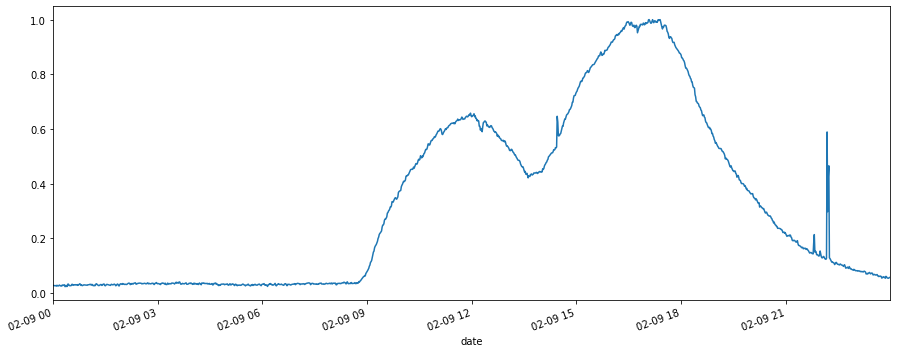

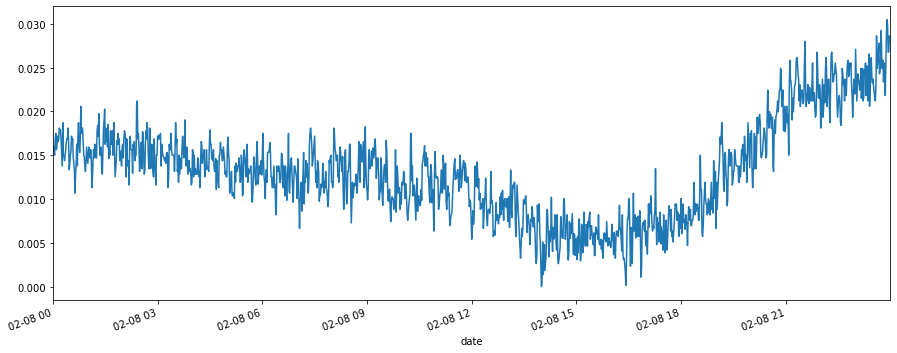

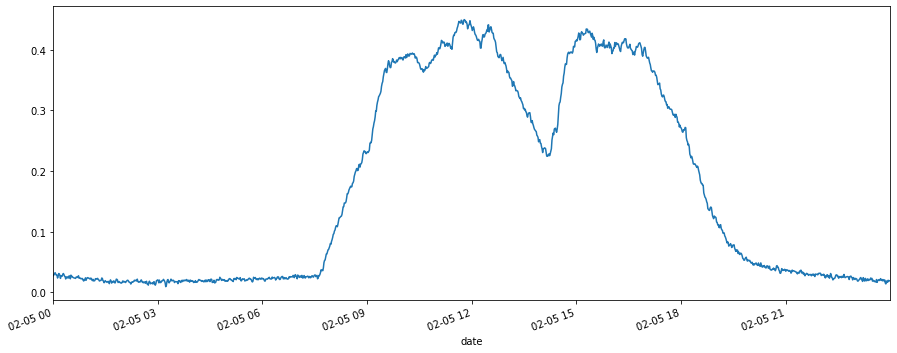

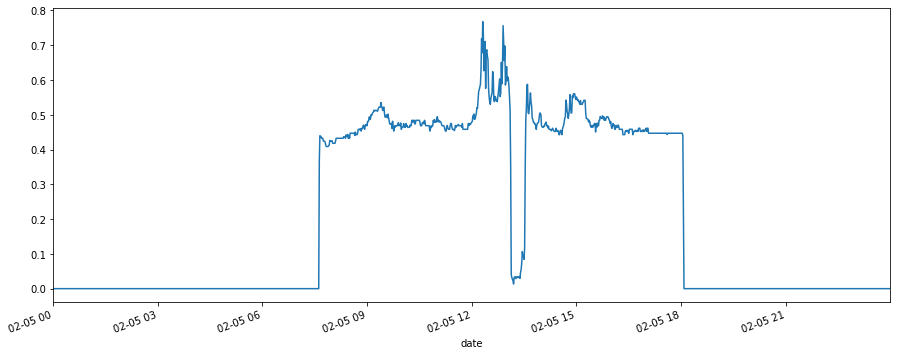

In [6]:
ts_Lunedi = df1['CO2']#[60*10:60*11]
ts_Lunedi.plot(figsize=(15, 6))
plt.xticks(rotation=20)
plt.show()

ts_Domenica = df2['CO2']#[60*10:60*11]
ts_Domenica.plot(figsize=(15, 6))
plt.xticks(rotation=20)
plt.show()

ts_Giovedi = df3['CO2']#[60*10:60*11]
ts_Giovedi.plot(figsize=(15, 6))
plt.xticks(rotation=20)
plt.show()

ts_Light = df4['Light']#[60*10:60*11]
ts_Light.plot(figsize=(15, 6))
plt.xticks(rotation=20)
plt.show()



Divido in gruppi di timeserie di ore e gruppi di time series di 6 ore il dataset CO2_5giorni

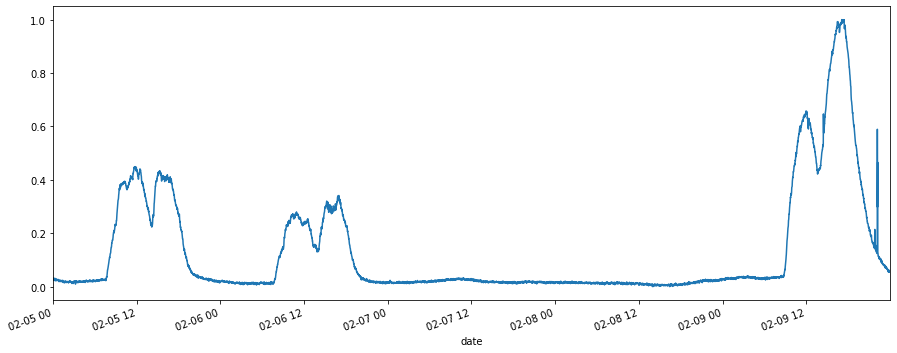

In [7]:
#Leggo il dataset
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d %H:%M:%S')
df_giorni = pd.read_csv('TimeSeries_DataSet/CO2/CO2_5Giorni.csv', parse_dates=True, index_col='date', date_parser=dateparse)

#Leggo la Time Series e plotto
ts_CO2 = df_giorni['CO2']
ts_CO2.plot(figsize=(15, 6))
plt.xticks(rotation=20)
plt.show()

#Creo la lista con la divisione ad ore
CO2_hour_list = []
dim = 24*5
for i in range(0, dim):
    CO2_hour_list.append(ts_CO2.values[60*i:60*(i+1)])
#Creo la lista con la divisione a 6 ore
CO2_6hour_list = []
for i in range(0, 20):
    CO2_6hour_list.append(ts_CO2.values[360*i:360*(i+1)])
    
#Trasformo in array
CO2_H_array = np.array(CO2_hour_list)
CO2_6H_array = np.array(CO2_6hour_list)


Link con la spiegazione delle distanze (con altre distanze)

https://www.kdnuggets.com/2017/08/comparing-distance-measurements-python-scipy.html

## Calcolo della distanza Euclidea

Calcolo della distanza euclidea tra:
- Lunedi e Domenica
- Lunedi e Giovedi

Nelle seguenti fasce:
- Tutto il giorno
- Dalle 11:30 alle 12:00
- Dalle 8:00 alle 19:00

In [8]:
dist1 = euclidean(ts_Lunedi, ts_Domenica)
dist2 = euclidean(ts_Lunedi[60*11+30:60*12], ts_Domenica[60*11+30:60*12])
dist3 = euclidean(ts_Lunedi[60*7:60*18], ts_Domenica[60*7:60*18])
print("Distanza tra Lunedi e Domenica: " + str(dist1))
print("Distanza tra Lunedi e Domenica (solo 11:30 - 12:00): " + str(dist2))
print("Distanza tra Lunedi e Domenica (solo 7:00 - 18:00): " + str(dist3))

dist1 = euclidean(ts_Lunedi, ts_Giovedi)
dist2 = euclidean(ts_Lunedi[60*11+30:60*12], ts_Giovedi[60*11+30:60*12])
dist3 = euclidean(ts_Lunedi[60*7:60*18], ts_Giovedi[60*7:60*18])
print("Distanza tra Lunedi e Giovedi: " + str(dist1))
print("Distanza tra Lunedi e Giovedi (solo 11:30 - 12:00): " + str(dist2))
print("Distanza tra Lunedi e Giovedi (solo 7:00 - 18:00): " + str(dist3))

Distanza tra Lunedi e Domenica: 17.147384423432083
Distanza tra Lunedi e Domenica (solo 11:30 - 12:00): 3.4311594003026413
Distanza tra Lunedi e Domenica (solo 7:00 - 18:00): 15.660123093529478
Distanza tra Lunedi e Giovedi: 9.851837583783974
Distanza tra Lunedi e Giovedi (solo 11:30 - 12:00): 1.0849213029103106
Distanza tra Lunedi e Giovedi (solo 7:00 - 18:00): 8.151698325506555


## Calcolo della distanza Manhattan

Calcolo della distanza manhattan tra:
- Lunedi e Domenica
- Lunedi e Giovedi

Nelle seguenti fasce:
- Tutto il giorno
- Dalle 11:30 alle 12:00
- Dalle 8:00 alle 19:00

In [9]:
dist1 = cityblock(ts_Lunedi, ts_Domenica)
dist2 = cityblock(ts_Lunedi[60*11+30:60*12], ts_Domenica[60*11+30:60*12])
dist3 = cityblock(ts_Lunedi[60*7:60*18], ts_Domenica[60*7:60*18])
print("Distanza tra Lunedi e Domenica: " + str(dist1))
print("Distanza tra Lunedi e Domenica (solo 11:30 - 12:00): " + str(dist2))
print("Distanza tra Lunedi e Domenica (solo 7:00 - 18:00): " + str(dist3))

dist1 = cityblock(ts_Lunedi, ts_Giovedi)
dist2 = cityblock(ts_Lunedi[60*11+30:60*12], ts_Giovedi[60*11+30:60*12])
dist3 = cityblock(ts_Lunedi[60*7:60*18], ts_Giovedi[60*7:60*18])
print("Distanza tra Lunedi e Giovedi: " + str(dist1))
print("Distanza tra Lunedi e Giovedi (solo 11:30 - 12:00): " + str(dist2))
print("Distanza tra Lunedi e Giovedi (solo 7:00 - 18:00): " + str(dist3))

Distanza tra Lunedi e Domenica: 454.31794832121307
Distanza tra Lunedi e Domenica (solo 11:30 - 12:00): 18.79065449481665
Distanza tra Lunedi e Domenica (solo 7:00 - 18:00): 344.3321316210222
Distanza tra Lunedi e Giovedi: 256.0396926092114
Distanza tra Lunedi e Giovedi (solo 11:30 - 12:00): 5.937541905203979
Distanza tra Lunedi e Giovedi (solo 7:00 - 18:00): 165.48293362215688


# Cosine similarity Distance

Calcolo della Cosine similarity tra:
- Lunedi e Domenica
- Lunedi e Giovedi

Nelle seguenti fasce:
- Tutto il giorno
- Dalle 11:30 alle 12:00
- Dalle 8:00 alle 19:00

In [10]:
dist1 = cosine(ts_Lunedi, ts_Domenica)
dist2 = cosine(ts_Lunedi[60*11+30:60*12], ts_Domenica[60*11+30:60*12])
dist3 = cosine(ts_Lunedi[60*7:60*18], ts_Domenica[60*7:60*18])
print("Distanza tra Lunedi e Domenica: " + str(dist1))
print("Distanza tra Lunedi e Domenica (solo 11:30 - 12:00): " + str(dist2))
print("Distanza tra Lunedi e Domenica (solo 7:00 - 18:00): " + str(dist3))

dist1 = cosine(ts_Lunedi, ts_Giovedi)
dist2 = cosine(ts_Lunedi[60*11+30:60*12], ts_Giovedi[60*11+30:60*12])
dist3 = cosine(ts_Lunedi[60*7:60*18], ts_Giovedi[60*7:60*18])
print("Distanza tra Lunedi e Giovedi: " + str(dist1))
print("Distanza tra Lunedi e Giovedi (solo 11:30 - 12:00): " + str(dist2))
print("Distanza tra Lunedi e Giovedi (solo 7:00 - 18:00): " + str(dist3))

Distanza tra Lunedi e Domenica: 0.516127179227722
Distanza tra Lunedi e Domenica (solo 11:30 - 12:00): 0.01032154594172452
Distanza tra Lunedi e Domenica (solo 7:00 - 18:00): 0.31509040016256806
Distanza tra Lunedi e Giovedi: 0.082696703280562
Distanza tra Lunedi e Giovedi (solo 11:30 - 12:00): 0.00010476877407650242
Distanza tra Lunedi e Giovedi (solo 7:00 - 18:00): 0.0598822959430938


## Dynamic Time Warping

Calcolo del Dynamic Time Warping tra:
- Lunedi e Domenica
- Lunedi e Giovedi

Nelle seguenti fasce:
- Tutto il giorno
- Dalle 11:30 alle 12:00
- Dalle 8:00 alle 19:00

In [11]:
path1, dist1 = dtw_path(ts_Lunedi, ts_Domenica)
path2, dist2 = dtw_path(ts_Lunedi[60*11+30:60*12], ts_Domenica[60*11+30:60*12])
path3, dist3 = dtw_path(ts_Lunedi[60*7:60*18], ts_Domenica[60*7:60*18])
print("Distanza tra Lunedi e Domenica: " + str(dist1))
print("Distanza tra Lunedi e Domenica (solo 11:30 - 12:00): " + str(dist2))
print("Distanza tra Lunedi e Domenica (solo 7:00 - 18:00): " + str(dist3))
path1, dist1 = dtw_path(ts_Lunedi, ts_Giovedi)
path2, dist2 = dtw_path(ts_Lunedi[60*11+30:60*12], ts_Giovedi[60*11+30:60*12])
path3, dist3 = dtw_path(ts_Lunedi[60*7:60*18], ts_Giovedi[60*7:60*18])
print("Distanza tra Lunedi e Giovedi: " + str(dist1))
print("Distanza tra Lunedi e Giovedi (solo 11:30 - 12:00): " + str(dist2))
print("Distanza tra Lunedi e Giovedi (solo 7:00 - 18:00): " + str(dist3))

Distanza tra Lunedi e Domenica: 16.599831077513123
Distanza tra Lunedi e Domenica (solo 11:30 - 12:00): 3.4311594003026413
Distanza tra Lunedi e Domenica (solo 7:00 - 18:00): 15.563571199607452
Distanza tra Lunedi e Giovedi: 7.201015150652714
Distanza tra Lunedi e Giovedi (solo 11:30 - 12:00): 1.0849213029103106
Distanza tra Lunedi e Giovedi (solo 7:00 - 18:00): 7.783897534847054


Versione con Sakoe-Chiba

In [12]:
path1, dist1 = dtw_path(ts_Lunedi, ts_Domenica, global_constraint="sakoe_chiba", sakoe_chiba_radius=2)
path2, dist2 = dtw_path(ts_Lunedi[60*11+30:60*12], ts_Domenica[60*11+30:60*12], global_constraint="sakoe_chiba", sakoe_chiba_radius=2)
path3, dist3 = dtw_path(ts_Lunedi[60*7:60*18], ts_Domenica[60*7:60*18], global_constraint="sakoe_chiba", sakoe_chiba_radius=2)
print("Distanza tra Lunedi e Domenica: " + str(dist1))
print("Distanza tra Lunedi e Domenica (solo 11:30 - 12:00): " + str(dist2))
print("Distanza tra Lunedi e Domenica (solo 7:00 - 18:00): " + str(dist3))
path1, dist1 = dtw_path(ts_Lunedi, ts_Giovedi, global_constraint="sakoe_chiba", sakoe_chiba_radius=2)
path2, dist2 = dtw_path(ts_Lunedi[60*11+30:60*12], ts_Giovedi[60*11+30:60*12], global_constraint="sakoe_chiba", sakoe_chiba_radius=2)
path3, dist3 = dtw_path(ts_Lunedi[60*7:60*18], ts_Giovedi[60*7:60*18], global_constraint="sakoe_chiba", sakoe_chiba_radius=2)
print("Distanza tra Lunedi e Giovedi: " + str(dist1))
print("Distanza tra Lunedi e Giovedi (solo 11:30 - 12:00): " + str(dist2))
print("Distanza tra Lunedi e Giovedi (solo 7:00 - 18:00): " + str(dist3))

Distanza tra Lunedi e Domenica: 17.146641284679333
Distanza tra Lunedi e Domenica (solo 11:30 - 12:00): 3.4311594003026413
Distanza tra Lunedi e Domenica (solo 7:00 - 18:00): 15.65962895043357
Distanza tra Lunedi e Giovedi: 9.788663018984787
Distanza tra Lunedi e Giovedi (solo 11:30 - 12:00): 1.0849213029103106
Distanza tra Lunedi e Giovedi (solo 7:00 - 18:00): 8.125762376301267


Versione con Itakura

In [13]:
path1, dist1 = dtw_path(ts_Lunedi, ts_Domenica, global_constraint="itakura", itakura_max_slope=2.)
path2, dist2 = dtw_path(ts_Lunedi[60*11+30:60*12], ts_Domenica[60*11+30:60*12],global_constraint="itakura", itakura_max_slope=2.)
path3, dist3 = dtw_path(ts_Lunedi[60*7:60*18], ts_Domenica[60*7:60*18], global_constraint="itakura", itakura_max_slope=2.)
print("Distanza tra Lunedi e Domenica: " + str(dist1))
print("Distanza tra Lunedi e Domenica (solo 11:30 - 12:00): " + str(dist2))
print("Distanza tra Lunedi e Domenica (solo 7:00 - 18:00): " + str(dist3))
path1, dist1 = dtw_path(ts_Lunedi, ts_Giovedi, global_constraint="itakura", itakura_max_slope=2.)
path2, dist2 = dtw_path(ts_Lunedi[60*11+30:60*12], ts_Giovedi[60*11+30:60*12], global_constraint="itakura", itakura_max_slope=2.)
path3, dist3 = dtw_path(ts_Lunedi[60*7:60*18], ts_Giovedi[60*7:60*18], global_constraint="itakura", itakura_max_slope=2.)
print("Distanza tra Lunedi e Giovedi: " + str(dist1))
print("Distanza tra Lunedi e Giovedi (solo 11:30 - 12:00): " + str(dist2))
print("Distanza tra Lunedi e Giovedi (solo 7:00 - 18:00): " + str(dist3))

Distanza tra Lunedi e Domenica: 16.943250863592713
Distanza tra Lunedi e Domenica (solo 11:30 - 12:00): 3.4311594003026413
Distanza tra Lunedi e Domenica (solo 7:00 - 18:00): 15.643577422822187
Distanza tra Lunedi e Giovedi: 7.59302660792667
Distanza tra Lunedi e Giovedi (solo 11:30 - 12:00): 1.0849213029103106
Distanza tra Lunedi e Giovedi (solo 7:00 - 18:00): 7.785190784570074


Esempio con un altro metodo: Lower Bound DTW

http://alexminnaar.com/2014/04/16/Time-Series-Classification-and-Clustering-with-Python.html

In [14]:
def LB_Keogh(s1,s2,r):
    LB_sum=0
    for ind,i in enumerate(s1):

        lower_bound=min(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        upper_bound=max(s2[(ind-r if ind-r>=0 else 0):(ind+r)])

        if i>upper_bound:
            LB_sum=LB_sum+(i-upper_bound)**2
        elif i<lower_bound:
            LB_sum=LB_sum+(i-lower_bound)**2

    return math.sqrt(LB_sum)

In [15]:
dist1 = LB_Keogh(ts_Lunedi, ts_Domenica, 10)
dist2 = LB_Keogh(ts_Lunedi[60*11+30:60*12], ts_Domenica[60*11+30:60*12], 10)
dist3 = LB_Keogh(ts_Lunedi[60*7:60*18], ts_Domenica[60*7:60*18], 10)
print("Distanza tra Lunedi e Domenica: " + str(dist1))
print("Distanza tra Lunedi e Domenica (solo 11:30 - 12:00): " + str(dist2))
print("Distanza tra Lunedi e Domenica (solo 7:00 - 18:00): " + str(dist3))
dist1 = LB_Keogh(ts_Lunedi, ts_Giovedi, 10)
dist2 = LB_Keogh(ts_Lunedi[60*11+30:60*12], ts_Giovedi[60*11+30:60*12], 10)
dist3 = LB_Keogh(ts_Lunedi[60*7:60*18], ts_Giovedi[60*7:60*18], 10)
print("Distanza tra Lunedi e Giovedi: " + str(dist1))
print("Distanza tra Lunedi e Giovedi (solo 11:30 - 12:00): " + str(dist2))
print("Distanza tra Lunedi e Giovedi (solo 7:00 - 18:00): " + str(dist3))

Distanza tra Lunedi e Domenica: 17.048546422804193
Distanza tra Lunedi e Domenica (solo 11:30 - 12:00): 3.4178626524533846
Distanza tra Lunedi e Domenica (solo 7:00 - 18:00): 15.580042518204497
Distanza tra Lunedi e Giovedi: 9.434279531304444
Distanza tra Lunedi e Giovedi (solo 11:30 - 12:00): 1.0406326300263546
Distanza tra Lunedi e Giovedi (solo 7:00 - 18:00): 7.80399189494964


Optimal path per Lunedi Domenica, nella fascia 07:00 - 18:00 :

- DTW normale
- Sakoe_Chiba
- Itakura

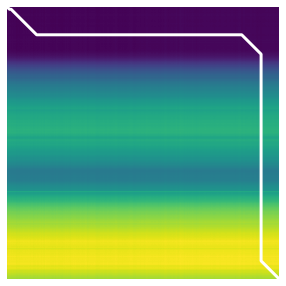

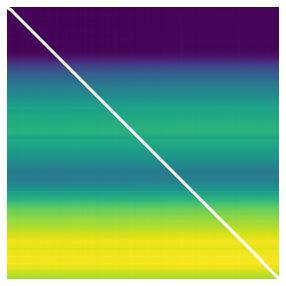

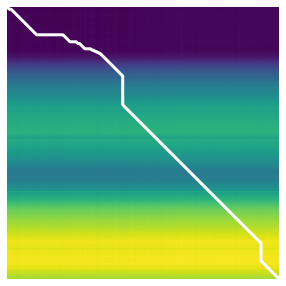

In [16]:
path2, dist2 = dtw_path(ts_Lunedi[60*7:60*18], ts_Domenica[60*7:60*18])

mat = cdist(ts_Lunedi.values[60*7:60*18].reshape(-1,1), ts_Domenica.values[60*7:60*18].reshape(-1,1))

plt.figure(figsize=(5, 5))
# la differenza con le slides è che  cominciamo dal punto in altro a sinistra e terminiamo con il punto in basso a destra
# Usando il path possiamo disegnare il best path
plt.imshow(mat)
plt.axis("off")
plt.autoscale(False)
plt.plot([j for (i, j) in path2], [i for (i, j) in path2], "w-", linewidth=3.)
plt.show()


path2, dist2 = dtw_path(ts_Lunedi.values[60*7:60*18], ts_Domenica.values[60*7:60*18], global_constraint="sakoe_chiba", sakoe_chiba_radius=2)

mat = cdist(ts_Lunedi.values[60*7:60*18].reshape(-1,1), ts_Domenica.values[60*7:60*18].reshape(-1,1))

plt.figure(figsize=(5, 5))
# la differenza con le slides è che  cominciamo dal punto in altro a sinistra e terminiamo con il punto in basso a destra
# Usando il path possiamo disegnare il best path
plt.imshow(mat)
plt.axis("off")
plt.autoscale(False)
plt.plot([j for (i, j) in path2], [i for (i, j) in path2], "w-", linewidth=3.)
plt.show()


path2, dist2 = dtw_path(ts_Lunedi.values[60*7:60*18], ts_Domenica.values[60*7:60*18], global_constraint="itakura", itakura_max_slope=2.)

mat = cdist(ts_Lunedi.values[60*7:60*18].reshape(-1,1), ts_Domenica.values[60*7:60*18].reshape(-1,1))

plt.figure(figsize=(5, 5))
# la differenza con le slides è che  cominciamo dal punto in altro a sinistra e terminiamo con il punto in basso a destra
# Usando il path possiamo disegnare il best path
plt.imshow(mat)
plt.axis("off")
plt.autoscale(False)
plt.plot([j for (i, j) in path2], [i for (i, j) in path2], "w-", linewidth=3.)
plt.show()

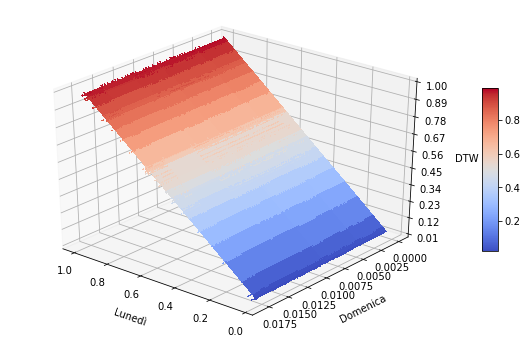

In [17]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

path2, dist2 = dtw_path(ts_Lunedi[60*7:60*18], ts_Domenica[60*7:60*18])

mat = cdist(ts_Lunedi.values[60*7:60*18].reshape(-1,1), ts_Domenica.values[60*7:60*18].reshape(-1,1))

mn = mat.min()
mx = mat.max()
X = ts_Lunedi.values[60*7:60*18]
Y = ts_Domenica.values[60*7:60*18]
Z= np.array(mat) 
X, Y = np.meshgrid(X, Y)

fig = plt.figure(figsize=(10,6))
ax = fig.gca(projection='3d')

# Plot the surface.
surf = ax.plot_surface(X, Y, Z.T, cmap=cm.coolwarm,
                       linewidth=100, antialiased=False)
#l = surf.plot_surface([i for (i, j, k) in path3], [j for (i, j, k) in path3])
#ax.plot([j for (i, j) in path2], [i for (i, j) in path2])

ax.set_xlabel('Lunedì', labelpad=10)
ax.set_ylabel('Domenica', labelpad=10)
ax.set_zlabel('DTW', labelpad=10)

# Customize the z axis.
ax.set_zlim(mn, mx)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.view_init(30, 130)


# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=10)

plt.show()


# Clustering

In [18]:
#Con il clustering Shape-based confronto direttamente le Time Series
#https://tslearn.readthedocs.io/en/stable/gen_modules/clustering/tslearn.clustering.TimeSeriesKMeans.html#tslearn.clustering.TimeSeriesKMeans

In [19]:
# TimeSeriesKMeans è migliore del normale Kmeans della sktlearn perché possiamo applicare il DTW
from tslearn.clustering import TimeSeriesKMeans
# Questa funzione crea una random_walks
from tslearn.generators import random_walks

c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [20]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d %H:%M:%S')
df_giorni = pd.read_csv('TimeSeries_DataSet/CO2/CO2_5Giorni.csv', parse_dates=True, index_col='date', date_parser=dateparse)
df_giorni1 = pd.read_csv('TimeSeries_DataSet/Temperature/Temperature_5Giorni.csv', parse_dates=True, index_col='date', date_parser=dateparse)
df_giorni2 = pd.read_csv('TimeSeries_DataSet/HumidityRatio/HumidityRatio_5Giorni.csv', parse_dates=True, index_col='date', date_parser=dateparse)

#Leggo la Time Series e plotto
ts_CO2 = df_giorni['CO2']
ts_Temperature = df_giorni1['Temperature']
ts_Humidity = df_giorni2['HumidityRatio']

In [21]:
"""#Creo la lista con la divisione a 6 ore
hour_list = []
for i in range(0, 20):
    hour_list.append(ts_CO2.values[360*i:360*(i+1)])
#Creo la lista con la divisione a 6 ore
for i in range(0, 20):
    hour_list.append(ts_Temperature.values[360*i:360*(i+1)])
#Creo la lista con la divisione a 6 ore
for i in range(0, 20):
    hour_list.append(ts_Humidity.values[360*i:360*(i+1)])
H_array = np.array(hour_list)"""


'#Creo la lista con la divisione a 6 ore\nhour_list = []\nfor i in range(0, 20):\n    hour_list.append(ts_CO2.values[360*i:360*(i+1)])\n#Creo la lista con la divisione a 6 ore\nfor i in range(0, 20):\n    hour_list.append(ts_Temperature.values[360*i:360*(i+1)])\n#Creo la lista con la divisione a 6 ore\nfor i in range(0, 20):\n    hour_list.append(ts_Humidity.values[360*i:360*(i+1)])\nH_array = np.array(hour_list)'

In [22]:
X  =CO2_6H_array

## Shape-based

In [404]:
X = CO2_H_array

X1 = CO2_H_array[0:48]
X2 = CO2_H_array[96:120]

X = np.concatenate((X1, X2), axis=0)

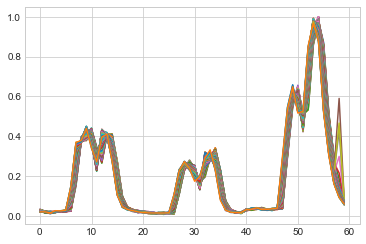

In [392]:
# Ora andiamo ad effettuare il cluster di questo dataset
plt.plot(X.reshape(X.shape[1], X.shape[0]))
plt.show()

In [393]:
# Faccio il calcolo dell'SSE e della silohuette
sse = []
silhouette = []
km_list = []
for i in range(2, 20):
    km = TimeSeriesKMeans(n_clusters=i, metric="dtw", max_iter=5, random_state=0)
    km.fit(X)
    sse.append(km.inertia_) #serve piccola
    label = km.labels_
    sil_coeff = silhouette_score(X, label, metric='euclidean')
    silhouette.append(sil_coeff)
    km_list.append(km)    

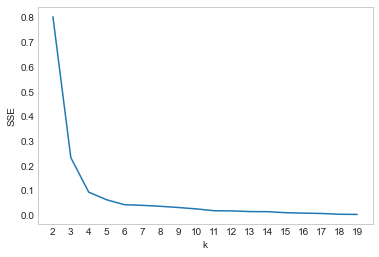

In [394]:
index = [i for i in range(2, 20)]
plt.figure()
plt.xticks(np.arange(2, 20, step=1))
plt.plot(index, sse)
plt.grid()
plt.xlabel("k")
plt.ylabel("SSE")
plt.show()

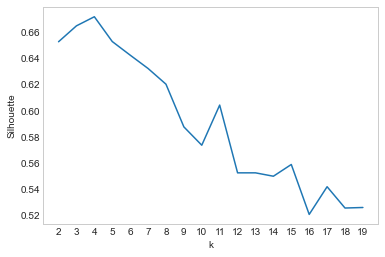

In [395]:
index = [i for i in range(2, 20)]
plt.figure()
plt.xticks(np.arange(2, 20, step=1))
plt.plot(index, silhouette)
plt.grid()
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.show()

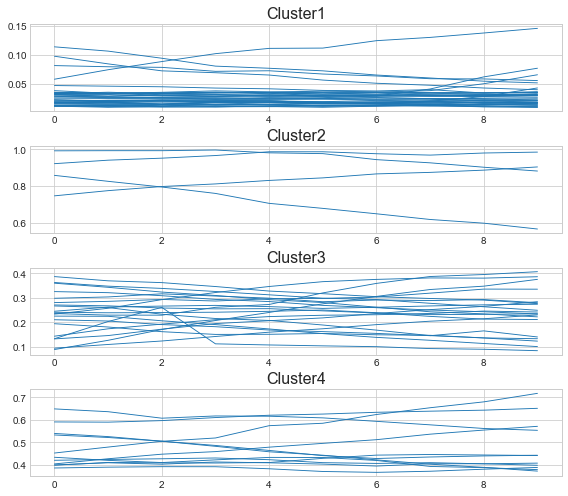

In [398]:
plt.figure(figsize=(8,7))

for i, classe in enumerate(['Cluster1', 'Cluster2', 'Cluster3', 'Cluster4']):
    plt.subplot(4, 1, i + 1)
    for x in X_paa[km_list[2].labels_ == i]:
        plt.plot(x, color='C0', linewidth=0.9)
    plt.title('{}'.format(classe), fontsize=16)
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()

Provo con "Euclidea"

In [412]:
km = TimeSeriesKMeans(n_clusters=4, metric="euclidean", max_iter=5, random_state=0)
km.fit(X)

TimeSeriesKMeans(dtw_inertia=False, init='k-means++', max_iter=5,
                 max_iter_barycenter=100, metric='euclidean',
                 metric_params=None, n_clusters=4, n_init=1, n_jobs=None,
                 random_state=0, tol=1e-06, verbose=0)

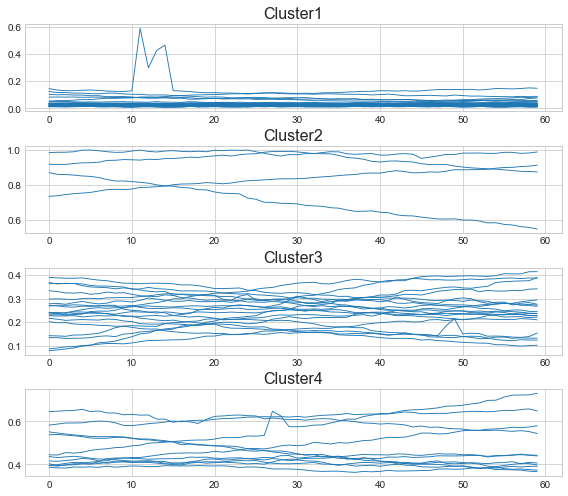

In [413]:
plt.figure(figsize=(8,7))

for i, classe in enumerate(['Cluster1', 'Cluster2', 'Cluster3', 'Cluster4']):
    plt.subplot(4, 1, i + 1)
    for x in X[km.labels_ == i]:
        plt.plot(x, color='C0', linewidth=0.9)
    plt.title('{}'.format(classe), fontsize=16)
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()

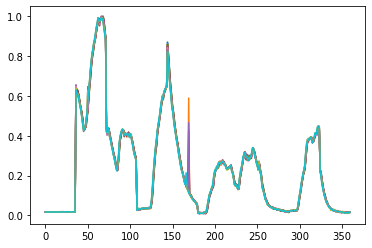

In [48]:
#Un po' diversa rispetto alla precedente perché la distanza euclidea non è la migliore per 
# fare il clustering
plt.plot(km.cluster_centers_.reshape(X.shape[1], 10))
plt.show()

In [266]:
km.labels_

array([0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2],
      dtype=int64)

In [50]:
km.inertia_

0.010134255368024791

In [51]:
km_dtw = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=5, random_state=0)
km_dtw.fit(X)

TimeSeriesKMeans(dtw_inertia=False, init='k-means++', max_iter=5,
                 max_iter_barycenter=100, metric='dtw', metric_params=None,
                 n_clusters=3, n_init=1, n_jobs=None, random_state=0, tol=1e-06,
                 verbose=0)

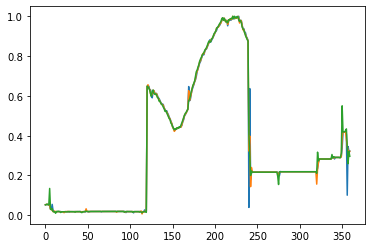

In [52]:
plt.plot(km_dtw.cluster_centers_.reshape(X.shape[1], 3))
plt.show()

In [198]:
km_dtw.labels_

array([0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 2, 1, 1, 1, 0, 0, 2, 0, 2, 1, 2, 0, 1, 1, 0, 1, 0, 1, 2, 1,
       0, 1, 1, 0, 1, 1], dtype=int64)

In [199]:
km_dtw.inertia_

57.59674673224943

## Features-based Clustering

In [23]:
X  =CO2_6H_array
X.shape

(20, 360)

In [24]:
def calculate_features(values):
    features = {
        'avg': np.mean(values),
        'std': np.std(values),
        'var': np.var(values),
        #'med': np.median(values),
        #'10p': np.percentile(values, 10),
        #'25p': np.percentile(values, 25),
        #'50p': np.percentile(values, 50),
        #'75p': np.percentile(values, 75),
        #'90p': np.percentile(values, 90),
        #'iqr': np.percentile(values, 75) - np.percentile(values, 25),
        #'cov': 1.0 * np.mean(values) / np.std(values),
        'skw': stats.skew(values),
        'kur': stats.kurtosis(values)
    }
    
    return features

In [25]:
from sklearn.cluster import KMeans

In [26]:
set_feature = []
for x in X:
    set_feature.append(calculate_features(x))
C = list(set_feature)
# In F metto il calculated features function (vista sopra con avarage, mean ecc)
#F = [list(calculate_features(x).values())[:-2] for x in X]
F = [list(calculate_features(x).values()) for x in X]

In [27]:
sse = []
silhouette = []
km_list = []
for i in range(2, 20):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(F)
    sse.append(kmeans.inertia_) #serve piccola
    label = kmeans.labels_
    sil_coeff = silhouette_score(F, label, metric='euclidean')
    silhouette.append(sil_coeff)
    km_list.append(kmeans)
    

Plot della sse
https://stackoverflow.com/questions/19197715/scikit-learn-k-means-elbow-criterion

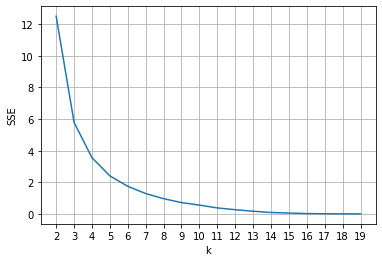

In [28]:
index = [i for i in range(2, 20)]
plt.figure()
plt.xticks(np.arange(2, 20, step=1))
plt.plot(index, sse)
plt.grid()
plt.xlabel("k")
plt.ylabel("SSE")
plt.show()

Plot della silhouette

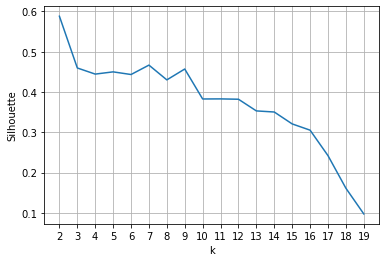

In [29]:
index = [i for i in range(2, 20)]
plt.figure()
plt.xticks(np.arange(2, 20, step=1))
plt.plot(index, silhouette)
plt.grid()
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.show()

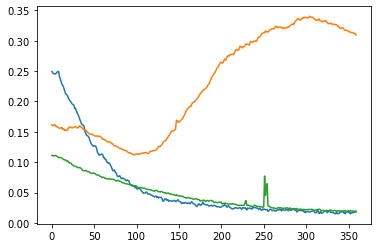

In [30]:
#Ora facciamo il plot dei valori medi, perché è utile per accedere/visualizzare il centroide in
# kmeans.inertia_
# Perché voglio qualcosa che sia rappresentabile
for i in range(3):
    plt.plot(np.mean(X[np.where(km_list[1].labels_ == i)[0]], axis=0))
plt.show()
# Il plot ha senso perchè più o meno tutte le time series cominciano da vicine poi una 
# aumenta molto, l'altra diminuisce molto, e la terza rimane stabile

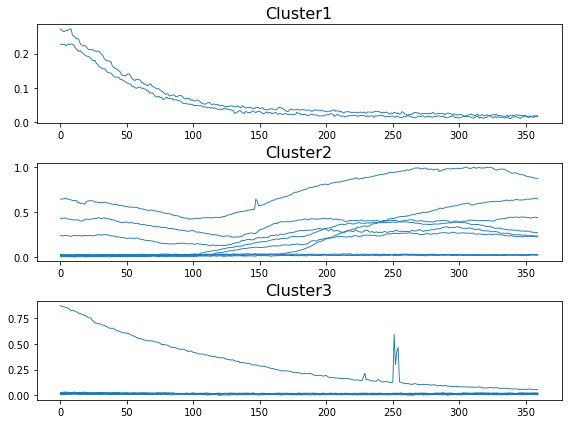

In [31]:
plt.figure(figsize=(8,6))

for i, classe in enumerate(['Cluster1', 'Cluster2', 'Cluster3']):
    plt.subplot(3, 1, i + 1)
    for x in X[km_list[1].labels_ == i]:
        plt.plot(x, color='C0', linewidth=0.9)
    plt.title('{}'.format(classe), fontsize=16)

plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()

TypeError: float() argument must be a string or a number, not 'dict'

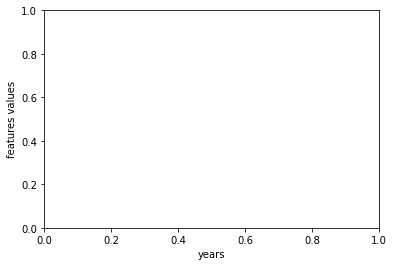

In [33]:

plt.xlabel('years')
plt.ylabel('features values')
plt.plot(C)
value=["mean","standard deviation","skew","kurtosis"]
legend(list(value))
plt.grid()

9


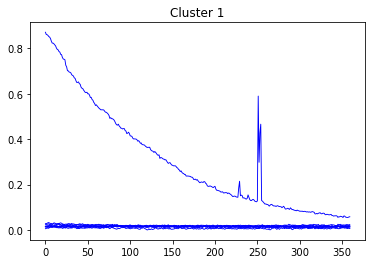

In [204]:
dim_clast1 = 0
list_clast1 = []
for x in X[km_list[1].labels_ == 0]:
    dim_clast1 = dim_clast1 + 1
    list_clast1.append(x)
    plt.plot(x, color='b', linewidth=0.9)
plt.title("Cluster 1")
print(dim_clast1)

Risultati del DIckey-Fuller Test:
Test Statistic                  -2.656460
p-value                          0.081880
#Lags Used                       8.000000
Number of Observations Used    351.000000
Critical Value (1%)             -3.449119
Critical Value (5%)             -2.869810
Critical Value (10%)            -2.571176
dtype: float64
Results of KPSS Test:
Test Statistic            0.613081
p-value                   0.021447
Lags Used                17.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)


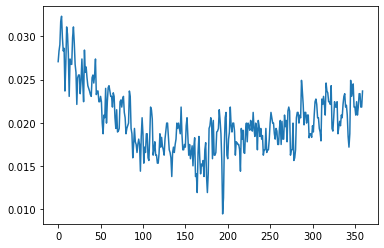

Risultati del DIckey-Fuller Test:
Test Statistic                  -2.422777
p-value                          0.135411
#Lags Used                      15.000000
Number of Observations Used    344.000000
Critical Value (1%)             -3.449503
Critical Value (5%)             -2.869979
Critical Value (10%)            -2.571266
dtype: float64
Results of KPSS Test:
Test Statistic            1.53123
p-value                   0.01000
Lags Used                17.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
dtype: float64


c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


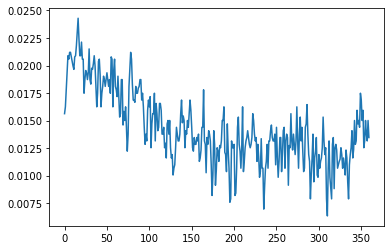

Risultati del DIckey-Fuller Test:
Test Statistic                  -3.120680
p-value                          0.025060
#Lags Used                       7.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64
Results of KPSS Test:
Test Statistic            1.470579
p-value                   0.010000
Lags Used                17.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


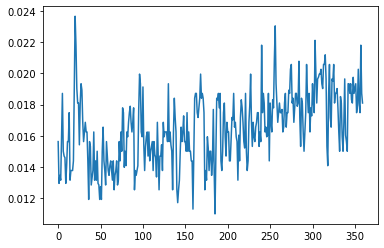

c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)


Risultati del DIckey-Fuller Test:
Test Statistic                  -2.367768
p-value                          0.151041
#Lags Used                      12.000000
Number of Observations Used    347.000000
Critical Value (1%)             -3.449337
Critical Value (5%)             -2.869906
Critical Value (10%)            -2.571227
dtype: float64
Results of KPSS Test:
Test Statistic            1.776649
p-value                   0.010000
Lags Used                17.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


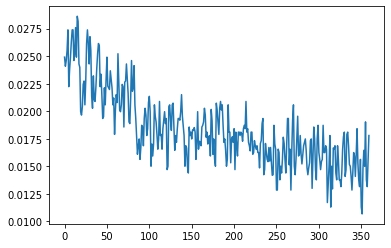

c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)


Risultati del DIckey-Fuller Test:
Test Statistic                  -3.023176
p-value                          0.032786
#Lags Used                       8.000000
Number of Observations Used    351.000000
Critical Value (1%)             -3.449119
Critical Value (5%)             -2.869810
Critical Value (10%)            -2.571176
dtype: float64
Results of KPSS Test:
Test Statistic            0.369847
p-value                   0.090152
Lags Used                17.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


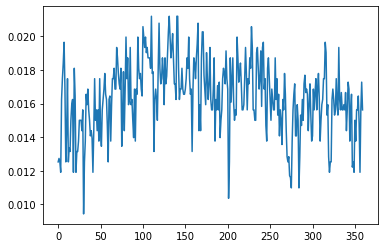

Risultati del DIckey-Fuller Test:
Test Statistic                -5.852767e+00
p-value                        3.557320e-07
#Lags Used                     3.000000e+00
Number of Observations Used    3.560000e+02
Critical Value (1%)           -3.448853e+00
Critical Value (5%)           -2.869693e+00
Critical Value (10%)          -2.571114e+00
dtype: float64
Results of KPSS Test:
Test Statistic            1.550058
p-value                   0.010000
Lags Used                17.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


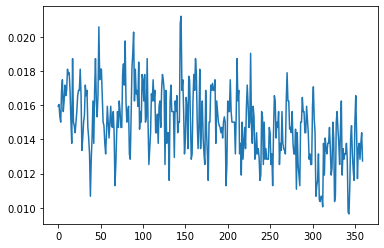

Risultati del DIckey-Fuller Test:
Test Statistic                -6.139321e+00
p-value                        8.042648e-08
#Lags Used                     3.000000e+00
Number of Observations Used    3.560000e+02
Critical Value (1%)           -3.448853e+00
Critical Value (5%)           -2.869693e+00
Critical Value (10%)          -2.571114e+00
dtype: float64
Results of KPSS Test:
Test Statistic            0.538465
p-value                   0.033003
Lags Used                17.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)


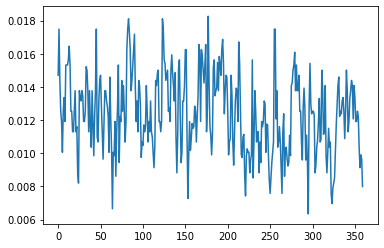

Risultati del DIckey-Fuller Test:
Test Statistic                  -5.610066
p-value                          0.000001
#Lags Used                       2.000000
Number of Observations Used    357.000000
Critical Value (1%)             -3.448801
Critical Value (5%)             -2.869670
Critical Value (10%)            -2.571101
dtype: float64

c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)



Results of KPSS Test:
Test Statistic            0.816205
p-value                   0.010000
Lags Used                17.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


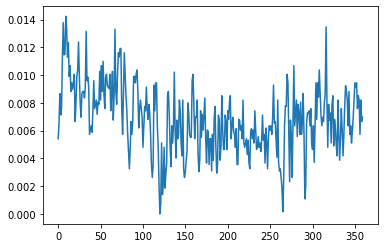

Risultati del DIckey-Fuller Test:
Test Statistic                  -3.988936
p-value                          0.001470
#Lags Used                      15.000000
Number of Observations Used    344.000000
Critical Value (1%)             -3.449503
Critical Value (5%)             -2.869979
Critical Value (10%)            -2.571266
dtype: float64
Results of KPSS Test:
Test Statistic            1.925822
p-value                   0.010000
Lags Used                17.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


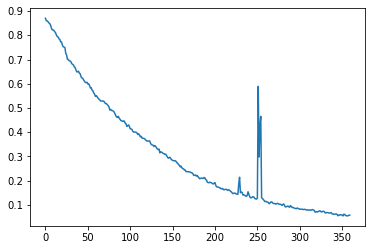

In [207]:
for i in list_clast1:
    adf_test(i)
    kpss_test(i)
    plt.plot(i)
    plt.show()

2


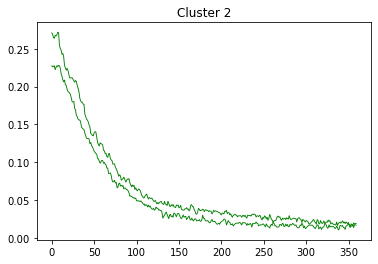

In [208]:
dim_clast2 = 0
list_clast2 = []
for x in X[km_list[1].labels_ == 1]:
    dim_clast2 = dim_clast2 + 1
    list_clast2.append(x)
    plt.plot(x, color='g', linewidth=0.9)
plt.title("Cluster 2")
print(dim_clast2)

Risultati del DIckey-Fuller Test:
Test Statistic                -8.587522e+00
p-value                        7.437624e-14
#Lags Used                     5.000000e+00
Number of Observations Used    3.540000e+02
Critical Value (1%)           -3.448958e+00
Critical Value (5%)           -2.869739e+00
Critical Value (10%)          -2.571138e+00
dtype: float64
Results of KPSS Test:
Test Statistic            1.485045
p-value                   0.010000
Lags Used                17.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


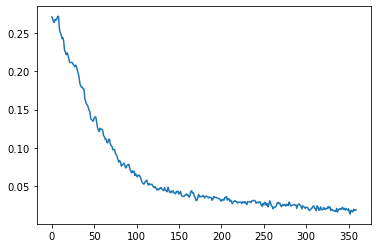

Risultati del DIckey-Fuller Test:
Test Statistic                -9.450693e+00
p-value                        4.625072e-16
#Lags Used                     9.000000e+00
Number of Observations Used    3.500000e+02
Critical Value (1%)           -3.449173e+00
Critical Value (5%)           -2.869833e+00
Critical Value (10%)          -2.571188e+00
dtype: float64
Results of KPSS Test:
Test Statistic            1.451687
p-value                   0.010000
Lags Used                17.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


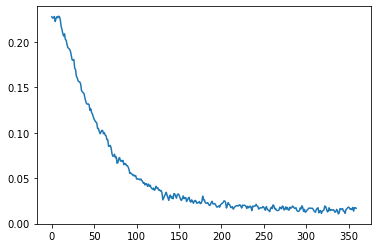

In [209]:
for i in list_clast2:
    adf_test(i)
    kpss_test(i)
    plt.plot(i)
    plt.show()

9


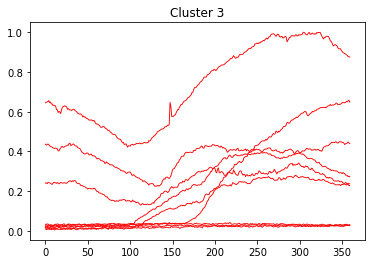

In [210]:
dim_clast3 = 0
list_clast3 = []
for x in X[km_list[1].labels_ == 2]:
    dim_clast3 = dim_clast3 + 1
    list_clast3.append(x)
    plt.plot(x, color='r', linewidth=0.9)
plt.title("Cluster 3")
print(dim_clast3)

Risultati del DIckey-Fuller Test:
Test Statistic                  -0.657148
p-value                          0.857539
#Lags Used                       7.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64
Results of KPSS Test:
Test Statistic            2.022168
p-value                   0.010000
Lags Used                17.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


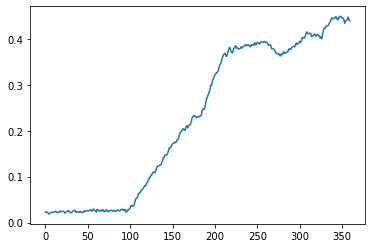

Risultati del DIckey-Fuller Test:
Test Statistic                  -1.601396
p-value                          0.482892
#Lags Used                       9.000000
Number of Observations Used    350.000000
Critical Value (1%)             -3.449173
Critical Value (5%)             -2.869833
Critical Value (10%)            -2.571188
dtype: float64
Results of KPSS Test:
Test Statistic            0.213239
p-value                   0.100000
Lags Used                17.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


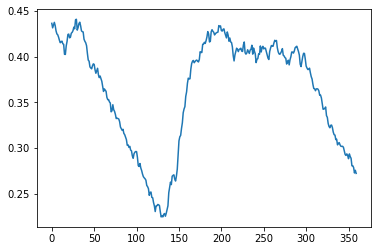

Risultati del DIckey-Fuller Test:
Test Statistic                  -1.054535
p-value                          0.732858
#Lags Used                      10.000000
Number of Observations Used    349.000000
Critical Value (1%)             -3.449227
Critical Value (5%)             -2.869857
Critical Value (10%)            -2.571201
dtype: float64

c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)



Results of KPSS Test:
Test Statistic            1.966838
p-value                   0.010000
Lags Used                17.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


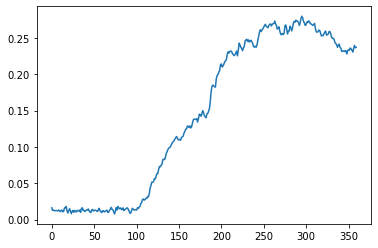

Risultati del DIckey-Fuller Test:
Test Statistic                  -1.857360
p-value                          0.352378
#Lags Used                      15.000000
Number of Observations Used    344.000000
Critical Value (1%)             -3.449503
Critical Value (5%)             -2.869979
Critical Value (10%)            -2.571266
dtype: float64
Results of KPSS Test:
Test Statistic            1.081678
p-value                   0.010000
Lags Used                17.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


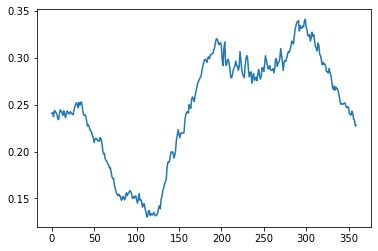

c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)


Risultati del DIckey-Fuller Test:
Test Statistic                  -1.756416
p-value                          0.402304
#Lags Used                      15.000000
Number of Observations Used    344.000000
Critical Value (1%)             -3.449503
Critical Value (5%)             -2.869979
Critical Value (10%)            -2.571266
dtype: float64
Results of KPSS Test:
Test Statistic            1.650665
p-value                   0.010000
Lags Used                17.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


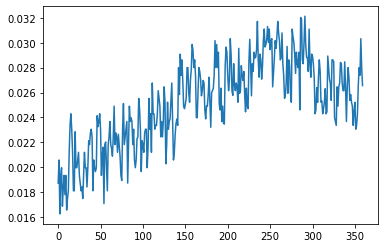

Risultati del DIckey-Fuller Test:
Test Statistic                  -1.244150
p-value                          0.654321
#Lags Used                      13.000000
Number of Observations Used    346.000000
Critical Value (1%)             -3.449392
Critical Value (5%)             -2.869930
Critical Value (10%)            -2.571240
dtype: float64
Results of KPSS Test:
Test Statistic            1.973642
p-value                   0.010000
Lags Used                17.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


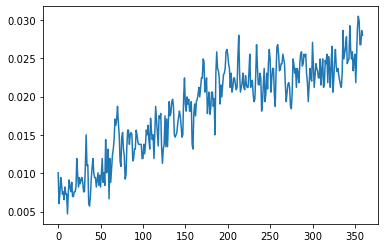

Risultati del DIckey-Fuller Test:
Test Statistic                  -2.017751
p-value                          0.278845
#Lags Used                       9.000000
Number of Observations Used    350.000000
Critical Value (1%)             -3.449173
Critical Value (5%)             -2.869833
Critical Value (10%)            -2.571188
dtype: float64
Results of KPSS Test:
Test Statistic            0.663052
p-value                   0.016904
Lags Used                17.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)


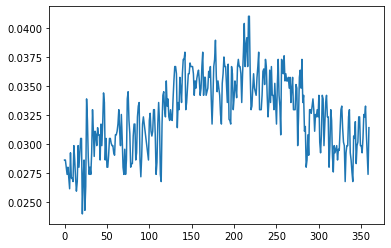

c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


Risultati del DIckey-Fuller Test:
Test Statistic                  -0.732000
p-value                          0.838286
#Lags Used                      13.000000
Number of Observations Used    346.000000
Critical Value (1%)             -3.449392
Critical Value (5%)             -2.869930
Critical Value (10%)            -2.571240
dtype: float64
Results of KPSS Test:
Test Statistic            1.906285
p-value                   0.010000
Lags Used                17.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


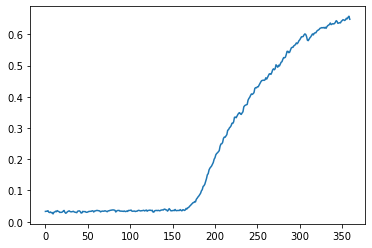

Risultati del DIckey-Fuller Test:


c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


Test Statistic                  -1.991037
p-value                          0.290517
#Lags Used                      17.000000
Number of Observations Used    342.000000
Critical Value (1%)             -3.449616
Critical Value (5%)             -2.870028
Critical Value (10%)            -2.571292
dtype: float64
Results of KPSS Test:
Test Statistic            1.72942
p-value                   0.01000
Lags Used                17.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
dtype: float64


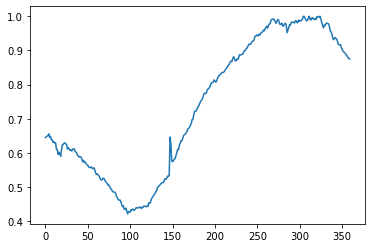

In [211]:
for i in list_clast3:
    adf_test(i)
    kpss_test(i)
    plt.plot(i)
    plt.show()

# Compression-based Clustering

In [208]:
from sklearn.metrics import pairwise_distances

In [209]:
#Usiamo il dbscan
def cdm_dist(x, y):
    #Incapsulo la string trasformation, la compressione e calcolo la distanza
    # Quindi (per ogni time series):
    # - trasformo in stringhe
    # - comprimo
    # - effettuo il calcolo
    x_str = (' '.join([str(v) for v in x.ravel()])).encode('utf-8')
    y_str = (' '.join([str(v) for v in y.ravel()])).encode('utf-8')
    return len(zlib.compress(x_str + y_str)) / (len(zlib.compress(x_str)) + len(zlib.compress(y_str)))

In [210]:
# Memorizzo la pairwise_distances su tutte le time series ma usando quella metrica definita sopra
M = pairwise_distances(X.reshape(X.shape[0], X.shape[1]), metric=cdm_dist)

In [211]:
# Ottengo una matrice 50*50
M.shape

(50, 50)

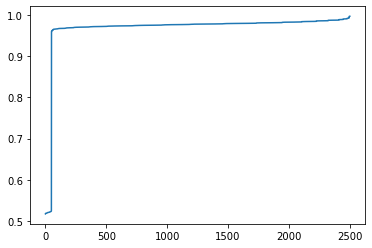

In [212]:
# osservo come va questa distanza (un plot ordinato di tutte le distanze)
plt.plot(sorted(M.ravel()))
plt.show()

In [213]:
# Importo il DBSCan
from sklearn.cluster import DBSCAN

In [214]:
# Sarebbe l'epsilon, quindi riguarda l'asse y del grafo precedente
dbscan = DBSCAN(eps=0.965, min_samples=5, metric='precomputed')
# Fitto passando le metriche
dbscan.fit(M)

DBSCAN(algorithm='auto', eps=0.965, leaf_size=30, metric='precomputed',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

In [215]:
# Queste sono le labels ottenute: ottengo un solo cluster con gli zeri messi vicini
# "-1" per quelli che si suppongono rumori
dbscan.labels_

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      dtype=int64)

# Approximated Clustering

In [220]:
from tslearn.piecewise import PiecewiseAggregateApproximation

In [361]:
X = CO2_H_array

In [375]:
X1 = CO2_H_array[0:48]
X2 = CO2_H_array[96:120]

In [378]:
X = np.concatenate((X1, X2), axis=0)

In [380]:
# In 10 segmenti 
n_paa_segments = 10
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
X_paa = paa.fit_transform(X)

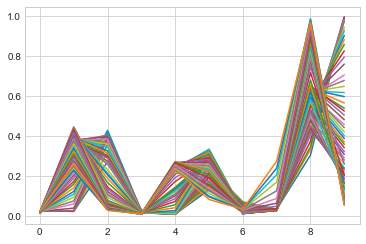

In [381]:
plt.plot(X_paa.reshape(X_paa.shape[1], X_paa.shape[0]))
plt.show()

In [364]:
from tslearn.clustering import TimeSeriesKMeans
sse = []
silhouette = []
km_list = []
for i in range(2, 20):
    km = TimeSeriesKMeans(n_clusters=i, metric="euclidean", max_iter=10, random_state=0)
    km.fit(X_paa)
    sse.append(km.inertia_) #serve piccola
    label = km.labels_
    #sil_coeff = silhouette_score(X_paa, label, metric='euclidean')
    #silhouette.append(sil_coeff)
    km_list.append(km)

In [382]:
sse = []
silhouette = []
km_list = []
for i in range(2, 20):
    km = TimeSeriesKMeans(n_clusters=i, metric="dtw", max_iter=10, random_state=0)
    km.fit(X_paa)
    sse.append(km.inertia_) #serve piccola
    label = km.labels_
    #sil_coeff = silhouette_score(X_paa, label, metric='euclidean')
    #silhouette.append(sil_coeff)
    km_list.append(km)
    

Plot della sse
https://stackoverflow.com/questions/19197715/scikit-learn-k-means-elbow-criterion

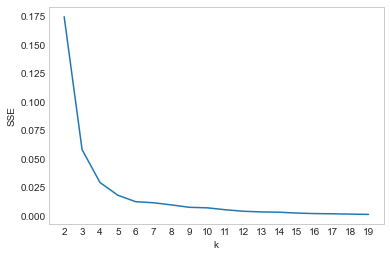

In [383]:
index = [i for i in range(2, 20)]
plt.figure()
plt.xticks(np.arange(2, 20, step=1))
plt.plot(index, sse)
plt.grid()
plt.xlabel("k")
plt.ylabel("SSE")
plt.show()

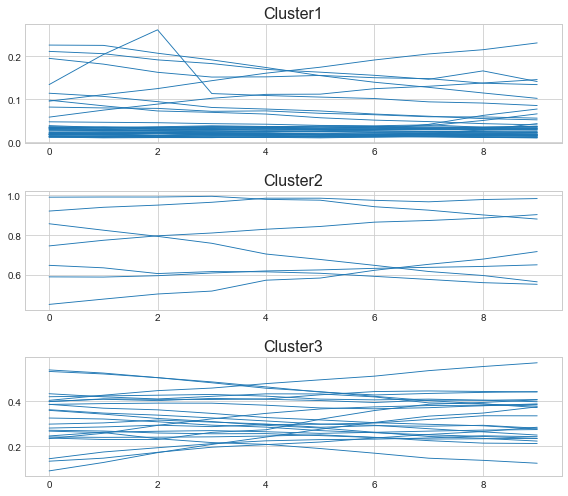

In [390]:
plt.figure(figsize=(8,7))

for i, classe in enumerate(['Cluster1', 'Cluster2', 'Cluster3', 'Cluster4']):
    plt.subplot(4, 1, i + 1)
    for x in X_paa[km_list[2].labels_ == i]:
        plt.plot(x, color='C0', linewidth=0.9)
    plt.title('{}'.format(classe), fontsize=16)
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()

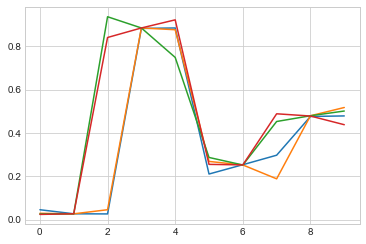

In [388]:
plt.plot(km_list[2].cluster_centers_.reshape(X_paa.shape[1], 4))
plt.show()

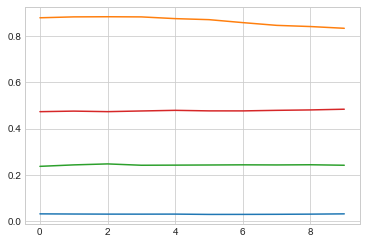

In [389]:
# Questo è quello che ottengo se guardo i valori medi rispetto a quelle labels
# Ottengo qualcosa di molto vicino rispetto a quello fatto nel featurebased clustering

#Fa la media di ogni time istant, quindi un punto che vediamo potrebbe probabilmente non essitere
for i in range(4):
    plt.plot(np.mean(X_paa[np.where(km_list[2].labels_ == i)[0]], axis=0))
    # Meglio usare medoid? che è più rappresentativo
plt.show()

# Hierarchical Clustering

https://python-timeseries.readthedocs.io/en/latest/model.html

In [318]:
X = CO2_H_array

In [319]:
from scipy.cluster.hierarchy import linkage, dendrogram
Z1 = linkage(X, method='single', metric='euclidean')
Z2 = linkage(X, method='complete', metric='euclidean')
Z3 = linkage(X, method='ward', metric='euclidean')

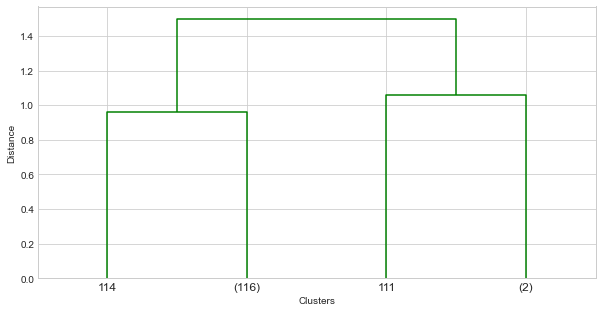

In [327]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(10, 5))
plt.xlabel('Clusters')
plt.ylabel('Distance')
ddata = dendrogram(Z1, color_threshold=113, orientation='top',
           truncate_mode='lastp',  # show only the last p merged clusters
           p=4,  # show only the last p merged clusters)
          )
# plot cluster points & distance labels
limit = 4
for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
    x = sum(i[1:3])/2
    y = d[1]
    if y > limit:
        plt.plot(x, y, 'o', c=c, markeredgewidth=0)
        plt.annotate(int(y), (x, y), xytext=(0, -5),
                    textcoords='offset points',
                    va='top', ha='center', fontsize=9)


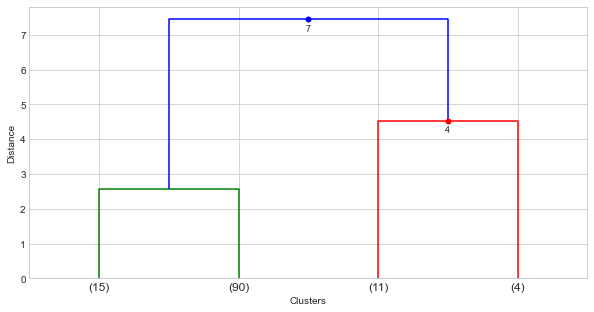

In [329]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(10, 5))
plt.xlabel('Clusters')
plt.ylabel('Distance')
ddata = dendrogram(Z2, color_threshold=5, orientation='top',
           truncate_mode='lastp',  # show only the last p merged clusters
           p=4,  # show only the last p merged clusters)
          )
# plot cluster points & distance labels
limit = 4
for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
    x = sum(i[1:3])/2
    y = d[1]
    if y > limit:
        plt.plot(x, y, 'o', c=c, markeredgewidth=0)
        plt.annotate(int(y), (x, y), xytext=(0, -5),
                    textcoords='offset points',
                    va='top', ha='center', fontsize=9)


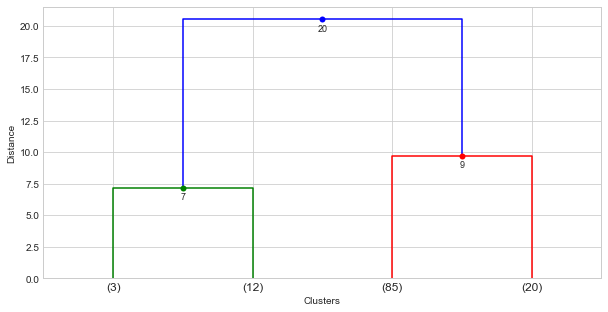

In [332]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(10, 5))
plt.xlabel('Clusters')
plt.ylabel('Distance')
ddata = dendrogram(Z3, color_threshold=10, orientation='top',
           truncate_mode='lastp',  # show only the last p merged clusters
           p=4,  # show only the last p merged clusters)
          )
# plot cluster points & distance labels
limit = 4
for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
    x = sum(i[1:3])/2
    y = d[1]
    if y > limit:
        plt.plot(x, y, 'o', c=c, markeredgewidth=0)
        plt.annotate(int(y), (x, y), xytext=(0, -5),
                    textcoords='offset points',
                    va='top', ha='center', fontsize=9)
